# Eigen mode decomposition: Satellite data LIM

Katie Brennan  
started August 2021  
  
#### Goals: 


In [1]:
import sys,os
import xarray as xr
import numpy as np
import scipy as spy
import pickle 

import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

import time as timestamp 

In [2]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils as lim

import LIM_utils_kb as limkb
import LIM_stats_kb as statskb
import LIM_plot_kb as plotkb
import LIM_building as limbuild

In [3]:
import importlib
importlib.reload(limkb)
importlib.reload(statskb)
importlib.reload(limbuild)

<module 'LIM_building' from '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_building.py'>

In [4]:
# %load_ext autoreload
# %autoreload 2

In [5]:
arc_proj = dict(projection=ccrs.Stereographic(central_latitude=90,
                                              central_longitude=-45,
                                              true_scale_latitude=0.1))
proj = dict(projection=ccrs.Robinson(central_longitude=0.),zorder=1)

In [6]:
month_names = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

In [6]:
# number of EOFs to retain for the LIM state vector
ntrunc = 30 # EOF truncation for individual fields (reduced-state space)
nmodes = 30 # number of coupled EOFs for LIM state space (truncated-state space)
#nmodes = 25
nmodes_sic = 60
#modes_sic = 20

mo='all'
#mo=0

# forecast lead time in months that defines the LIM training
tau = 1

# training data defined by the first ntrain times
# fraction of years used in training
# ensures that start year of both train and validation data is january 
ntrain = int(25*12)
nvalid = int(38*12)
nyearsvalid = 38-25
nvalidtimes = 1872

# variables to include in the LIM (note "vars" is a Python command)
#limvars = ['tas','zg']
#limvars = ['tas','rlut','zg']
#limvars = ['sic']
#limvars = ['tas','sic']
#limvars = ['tas','sic','zg','psl','pr','tos']
#limvars = ['tas','psl','tos','sit','sic']
# limvars = ['tas','tos','psl','sit','sic']
# limvars_nosic = ['tas','tos','psl','sit']
#limvars = ['tas','tos','psl','sit','sic']
limvars = ['sic']
limvars_nosic = []
nvars = len(limvars)

# specify the model source 
train_dsource = 'satellite'
#train_dsource = 'mpi_hist_kb'
#train_dsource = 'ccsm4_lm_kb'
valid_dsource = 'satellite'
#valid_dsource = 'mpi_lm_kb'
#valid_dsource = 'ccsm4_lm_kb'

sic_separate = True
Insamp = False

In [7]:
from datetime import date

today = date.today()

#Year-month-day
today_date = today.strftime("%Y%m%d")

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
fdic_train = limkb.build_training_dic(train_dsource)
fdic_valid = limkb.build_training_dic(valid_dsource)

full_names, areawt_name, month_names = limbuild.load_full_names()

In [11]:
### Load cellarea file for satellite data: 
areacello = xr.open_dataset(fdic_train['fpath']+fdic_train['areacello'])

areacell = {}
areacell['areacello'] = areacello['areacello'].values

areacell_dict = {}
areacello_d = {}
areacello_d['lat'] = areacello.lat.values
areacello_d['lon'] = areacello.lon.values
areacello_d['units'] = 'km2'
areacello_d['ndof'] = 448*304

areacell_dict['areacello'] = areacello_d

## Build L from scratch: 

### Truncate training data: 

In [12]:
wt=True
dt = False
var_dict = {}
var = 'sic'
var_ln = 'goddard_merged_seaice_conc_monthly'
    
X_var, var_dict = limkb.load_sat_data(var, var_ln,var_dict, fdic_train, 
                                      remove_climo=True, detrend=dt, verbose=True)

#X_var_filled = np.where((var_dict['sic']['lat']>82),1.0,X_var)

if dt is False: 
    x_var = np.reshape(X_var,(X_var.shape[0],X_var.shape[1]*X_var.shape[2])).T
else: 
    x_var = X_var

ntime = x_var.shape[1]
X_var_train = x_var[:,0:ntrain]
X_var_valid = x_var[:,ntrain:nvalid]

acell = areacell['areacello']
if len(acell.shape)>1:
    acell_1d = np.reshape(acell,(acell.shape[0]*acell.shape[1]))
else: 
    acell_1d = acell

[Ptrunc, E3, tot_var,
 tot_var_eig, W_all, 
 standard_factor] = limkb.step1_compress_individual_var(X_var_train, var, ntrunc, nmodes_sic, 
                                                              var_dict, areawt=acell_1d,
                                                              wt=wt, sic_separate=True)

Loading sic
removing climotology...
-----------------------------------------------------
completed in 3.7860679626464844 seconds
-----------------------------------------------------
truncating to 60
fraction in first 60 sic EOFs = 84.18024134482974


In [13]:
ndof_all = E3.shape[0]
P_train = Ptrunc

## Train LIM: 

In [14]:
tau

1

In [15]:
if mo is 'all':
    LIMd2, G2 = lim.LIM_train(tau,P_train)
    print('Training LIM with tau = '+str(tau))
else: 
    LIMd2, G2 = lim.LIM_train_flex(tau,P_train[:,:-1], P_train[:,1:])
#    LIMd2, G2 = lim.LIM_train_flex(tau,P_train_3d[:,:,0], P_train_3d[:,:,1])
    print('Training LIM with tau = '+str(tau))

Training LIM with tau = 1


In [16]:
max_eigenval = np.real(LIMd2['lam_L']).max()

if max_eigenval >0: 
    LIMd2['lam_L_adj'] = LIMd2['lam_L'] - (max_eigenval+0.01)
else: 
    LIMd2['lam_L_adj'] = LIMd2['lam_L']

#### Any positive eigenvalues in L?

In [17]:
(LIMd2['lam_L']>0).sum()/(LIMd2['lam_L'].shape[0])

0.0

In [19]:
t = 1

G = LIMd2['Gt']
L = np.log(G)/t

In [20]:
G

array([[ 0.8899843 , -0.02792339, -0.02991175, ...,  0.11365799,
         0.35830001, -0.04321492],
       [ 0.01773741,  0.79348803, -0.10323674, ...,  0.23620434,
         0.02725699, -0.48318682],
       [-0.03415579,  0.01370076,  0.79147137, ...,  0.12649284,
        -0.16271781,  0.02212525],
       ...,
       [-0.00351223, -0.00904584, -0.00938036, ...,  0.32934186,
        -0.07773614, -0.00784261],
       [ 0.00458273,  0.0035224 ,  0.00251941, ...,  0.0334544 ,
         0.40573866,  0.06130587],
       [-0.00436494,  0.01240144, -0.00303402, ..., -0.12664412,
        -0.00856362,  0.29685739]])

In [22]:
Gt = np.matmul(np.matmul(LIMd2['vec'],np.diag(np.exp(LIMd2['lam_L']*t))),LIMd2['veci'])
Lt = np.matmul(np.matmul(LIMd2['vec'],np.diag(LIMd2['lam_L'])),LIMd2['veci'])

In [25]:
Gt

array([[ 0.8899843 -2.38413630e-16j, -0.02792339+1.69280334e-16j,
        -0.02991175-1.57732821e-16j, ...,  0.11365799-1.77285795e-16j,
         0.35830001+6.00339563e-16j, -0.04321492+3.10790343e-16j],
       [ 0.01773741+1.40156377e-16j,  0.79348803+4.48089637e-16j,
        -0.10323674-2.77203916e-16j, ...,  0.23620434+1.34729295e-15j,
         0.02725699+2.27777808e-16j, -0.48318682-1.06479537e-15j],
       [-0.03415579+1.22989356e-16j,  0.01370076+2.82330718e-16j,
         0.79147137+2.83520299e-16j, ...,  0.12649284-5.24117984e-16j,
        -0.16271781-3.32312105e-16j,  0.02212525+8.44023561e-17j],
       ...,
       [-0.00351223-2.95757242e-17j, -0.00904584+5.01941261e-17j,
        -0.00938036+1.32450825e-16j, ...,  0.32934186-1.77636404e-16j,
        -0.07773614-4.63536166e-16j, -0.00784261+8.96191061e-17j],
       [ 0.00458273-1.10355329e-17j,  0.0035224 +4.59339902e-17j,
         0.00251941+1.75165726e-17j, ...,  0.0334544 +5.99624199e-17j,
         0.40573866-2.87667679e-17j

## Empirical Normal Modes: 

In [26]:
LIMd2.keys()

dict_keys(['vec', 'veci', 'val', 'lam_L', 'Gt', 'lam_L_adj'])

In [27]:
alpha = np.real(LIMd2['lam_L'])
omega = np.imag(LIMd2['lam_L'])

In [29]:
pi = np.pi
period = 2*pi/(omega)
decay_times = -1/alpha

| Mode | Decay time<br>(months) | Period<br>(months) | bTb | Growth Index |
| :-: | :-: | :-: | :-: | :-: | 
| 29 | 15.27 | $\infty$ |
| 47 | 6.12 | $\infty$ |
| 50 | 4.97 | $\infty$ |
| 51 | 4.56 | $\infty$ |
| 45/46 | 4.53 | 35.22 |
| 35/36 | 3.87 | 19.26 |
| 31/32 | 3.82 | 16.41 |
| 52/53 | 3.74 | 124.5 |
| 49/50 | 3.08 | 33.77 |

In [49]:
n = 12
decay_times[np.flip(np.argsort(decay_times))][n], period[np.flip(np.argsort(decay_times))][n], np.flip(np.argsort(decay_times))[n]

(3.075154852849701, -33.7727405055513, 49)

In [50]:
P = alpha**t*(np.cos(omega*t)*np.real(LIMd2['vec'])-np.sin(omega*t)*np.imag(LIMd2['vec']))

In [51]:
# t =1

# Gt = np.matmul(np.matmul(LIMd2['vec'],np.diag(np.exp(LIMd2['lam_L_adj']*t))),LIMd2['veci'])
# L = np.log(Gt)/t

# val,vec = np.linalg.eig(L)
# veci = np.linalg.inv(vec)
# lam_L = np.log(val)/tau

# Ldict = {}
# Ldict['vec'] = vec
# Ldict['veci'] = veci
# Ldict['val'] = val
# Ldict['lam_L'] = lam_L
# Ldict['L']= L

In [74]:
x_train_sic_dcomp = np.matmul(E3,LIMd2['vec'])
nmodes = E3.shape[1]
Weights=True

if Weights is True: 
    X_train_dcomp = np.zeros_like(x_train_sic_dcomp)

    start=0
    for var in (limvars):
        inds_end = var_dict[var]['var_ndof']
        X_train_dcomp[start:start+inds_end,:] = x_train_sic_dcomp[start:start+inds_end,:]/W_all[:,np.newaxis]
        start = start+inds_end
        
L_vec_decomp = X_train_dcomp

In [87]:
L_vec_decomp_var  = {}
start = 0
size = 0

for i,var in enumerate(limvars):
    print('Working on ...'+var)
    size = E3.shape[0]
    hold = L_vec_decomp[start:start+size,:]
    print(hold.shape)
    if len(var_dict[var]['lat'].shape)>1:
        la = var_dict[var]['lat'].shape[0]
        lo = var_dict[var]['lon'].shape[1]
    else:
        la = var_dict[var]['lat'].shape[0]
        lo = var_dict[var]['lon'].shape[0]
    print('shape: '+str(la)+', '+str(lo))
    L_vec_decomp_var[var] = np.reshape(hold,(la,lo,60))
    
    start = start+size

Working on ...sic
(136192, 60)
shape: 448, 304


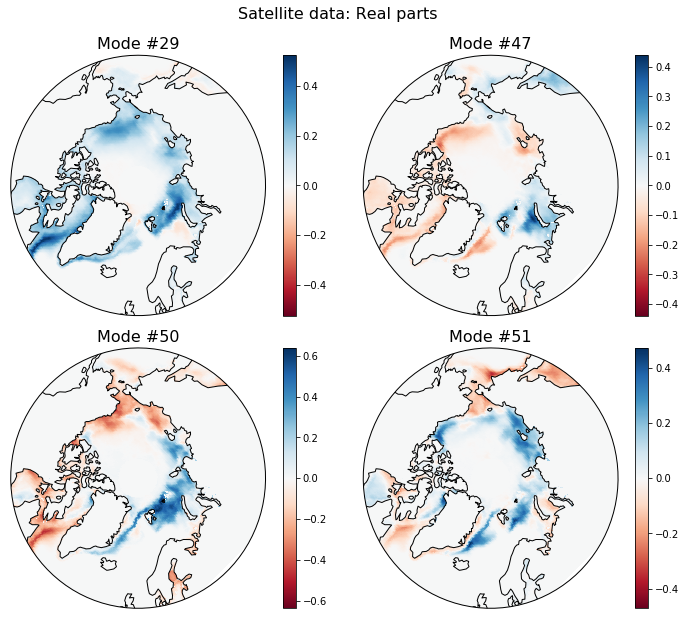

In [91]:
import matplotlib.path as mpath

modes = [45,47,50,51]
var = 'sic'

fig, axs = plt.subplots(2,2,figsize=(10,9),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()
fig.subplots_adjust(bottom=0.05, top=0.95,
                        left=0.04, right=0.95, wspace=0.02)

for i,mode in enumerate(modes):
    ax[i].set_title('Mode #'+str(mode), fontsize=16)
    ax[i].coastlines()
    fig.colorbar(cf, ax=ax[i])
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
    
    m = np.max(np.abs(np.real(L_vec_decomp_var[var][:,:,mode])))
    cf = ax[i].pcolormesh(var_dict[var]['lon'],var_dict[var]['lat'],
                          np.real(L_vec_decomp_var[var][:,:,mode]),cmap='RdBu', 
                          transform=ccrs.PlateCarree(),vmin=-m,vmax=m)
    
plt.suptitle('Satellite data: Real parts', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

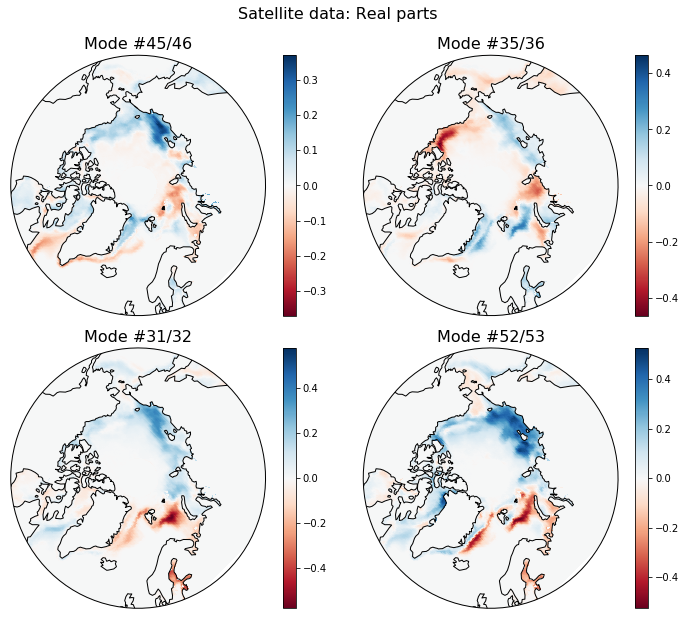

In [95]:
import matplotlib.path as mpath

modes = [45, 35, 31, 52]
var = 'sic'

fig, axs = plt.subplots(2,2,figsize=(10,9),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()
fig.subplots_adjust(bottom=0.05, top=0.95,
                        left=0.04, right=0.95, wspace=0.02)

for i,mode in enumerate(modes):
    ax[i].set_title('Mode #'+str(mode)+'/'+str(mode+1), fontsize=16)
    ax[i].coastlines()
    fig.colorbar(cf, ax=ax[i])
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
    
    m = np.max(np.abs(np.real(L_vec_decomp_var[var][:,:,mode])))
    cf = ax[i].pcolormesh(var_dict[var]['lon'],var_dict[var]['lat'],
                          np.real(L_vec_decomp_var[var][:,:,mode]),cmap='RdBu', 
                          transform=ccrs.PlateCarree(),vmin=-m,vmax=m)
    
plt.suptitle('Satellite data: Real parts', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

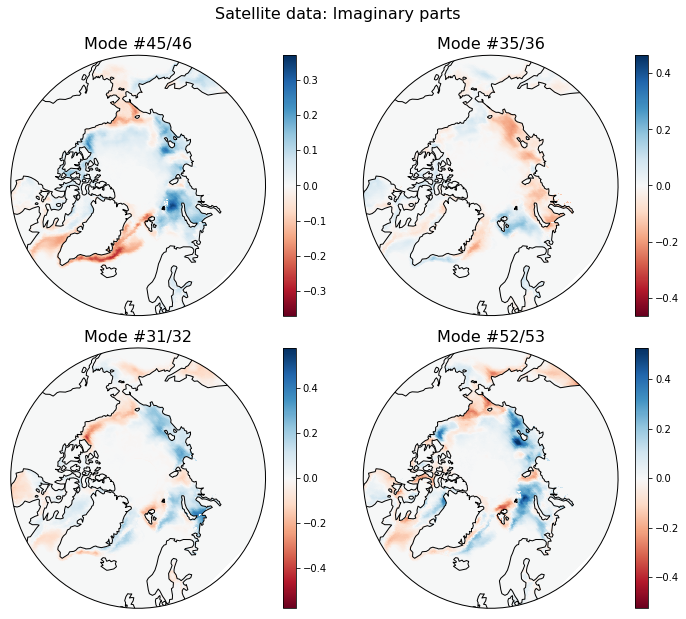

In [96]:
import matplotlib.path as mpath

modes = [45, 35, 31, 52]
var = 'sic'

fig, axs = plt.subplots(2,2,figsize=(10,9),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()
fig.subplots_adjust(bottom=0.05, top=0.95,
                        left=0.04, right=0.95, wspace=0.02)

for i,mode in enumerate(modes):
    ax[i].set_title('Mode #'+str(mode)+'/'+str(mode+1), fontsize=16)
    ax[i].coastlines()
    fig.colorbar(cf, ax=ax[i])
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
    
    m = np.max(np.abs(np.real(L_vec_decomp_var[var][:,:,mode])))
    cf = ax[i].pcolormesh(var_dict[var]['lon'],var_dict[var]['lat'],
                          np.imag(L_vec_decomp_var[var][:,:,mode]),cmap='RdBu', 
                          transform=ccrs.PlateCarree(),vmin=-m,vmax=m)
    
plt.suptitle('Satellite data: Imaginary parts', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

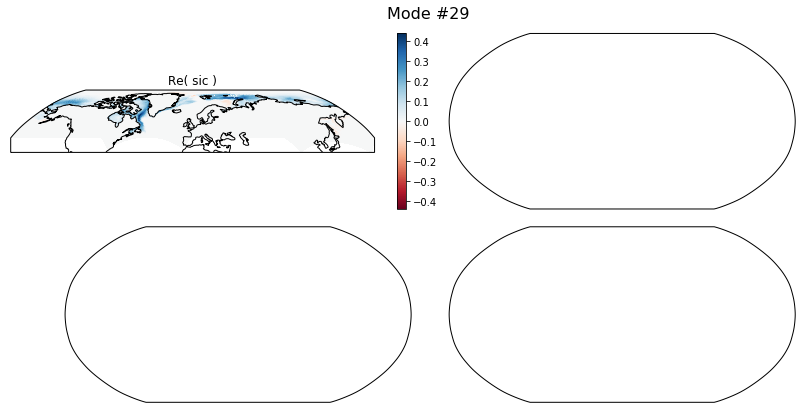

In [88]:
fig, axs = plt.subplots(2,2,figsize=(12,6),subplot_kw={'projection': ccrs.Robinson()})
ax = axs.flatten()
mode = 29

for i,var in enumerate(limvars):
    m = np.max(np.abs(np.real(L_vec_decomp_var[var][:,:,mode])))
    cf = ax[i].pcolormesh(var_dict[var]['lon'],var_dict[var]['lat'],
                          np.real(L_vec_decomp_var[var][:,:,mode]),cmap='RdBu', 
                          transform=ccrs.PlateCarree(),vmin=-m,vmax=m)
    ax[i].set_title('Re( '+var+' )')
    ax[i].coastlines()
    
    fig.colorbar(cf, ax=ax[i])
    
plt.suptitle('Mode #'+str(mode), fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

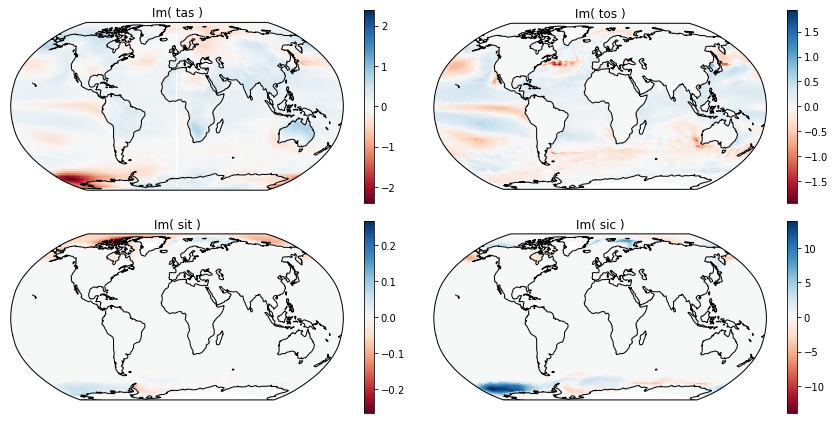

In [364]:
fig, axs = plt.subplots(2,2,figsize=(12,6),subplot_kw={'projection': ccrs.Robinson()})
ax = axs.flatten()

for i,var in enumerate(limvars):
    m = np.max(np.abs(np.imag(L_vec_decomp_var[var][:,:,mode])))
    cf = ax[i].pcolormesh(var_dict[var]['lon'],var_dict[var]['lat'],
                          np.imag(L_vec_decomp_var[var][:,:,mode]),cmap='RdBu', 
                          transform=ccrs.PlateCarree(),vmin=-m,vmax=m)
    ax[i].set_title('Im( '+var+' )')
    ax[i].coastlines()
    
    fig.colorbar(cf, ax=ax[i])
    
plt.suptitle('Mode #'+str(mode), fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

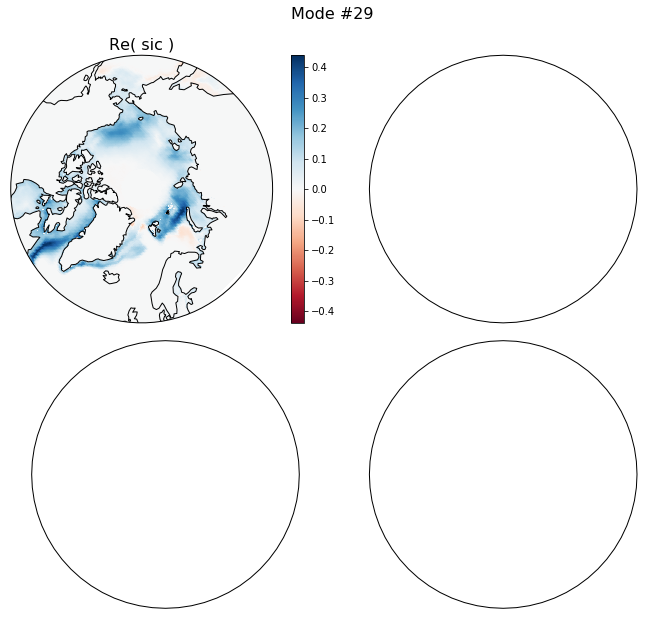

In [89]:
import matplotlib.path as mpath
fig, axs = plt.subplots(2,2,figsize=(10,9),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()
fig.subplots_adjust(bottom=0.05, top=0.95,
                        left=0.04, right=0.95, wspace=0.02)

for i,var in enumerate(limvars):
    ax[i].set_title('Re( '+var+' )', fontsize=16)
    ax[i].coastlines()
    fig.colorbar(cf, ax=ax[i])
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
    
    m = np.max(np.abs(np.real(L_vec_decomp_var[var][:,:,mode])))
    cf = ax[i].pcolormesh(var_dict[var]['lon'],var_dict[var]['lat'],
                          np.real(L_vec_decomp_var[var][:,:,mode]),cmap='RdBu', 
                          transform=ccrs.PlateCarree(),vmin=-m,vmax=m)
    
plt.suptitle('Mode #'+str(mode), fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

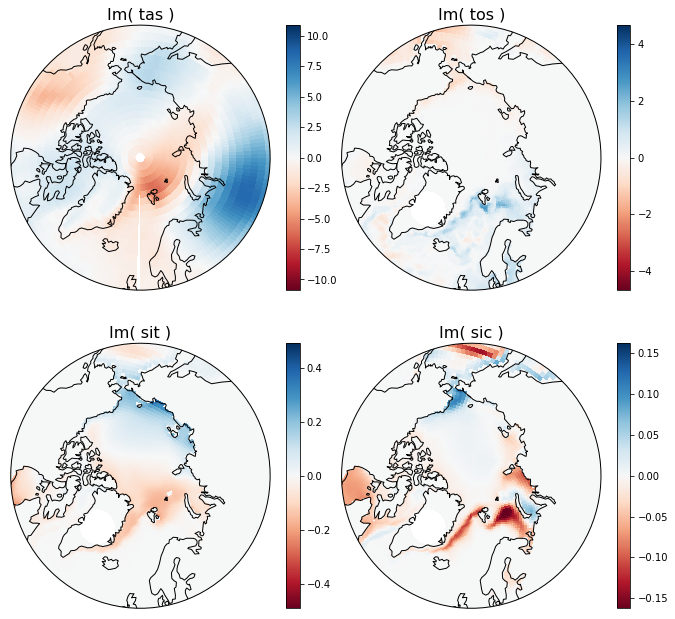

In [366]:
import matplotlib.path as mpath
fig, axs = plt.subplots(2,2,figsize=(10,9),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()
fig.subplots_adjust(bottom=0.05, top=0.95,
                        left=0.04, right=0.95, wspace=0.02)
mode = 0

for i,var in enumerate(limvars):
    ax[i].set_title('Im( '+var+' )', fontsize=16)
    ax[i].coastlines()
    fig.colorbar(cf, ax=ax[i])
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
    
    m = np.max(np.abs(np.real(L_vec_decomp_var[var][:,:,mode])))
    cf = ax[i].pcolormesh(var_dict[var]['lon'],var_dict[var]['lat'],
                          np.imag(L_vec_decomp_var[var][:,:,mode]),cmap='RdBu', 
                          transform=ccrs.PlateCarree(),vmin=-m,vmax=m)
    
plt.suptitle('Mode #'+str(mode), fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])